# Model

Import all needed in this notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoImageProcessor, ResNetForImageClassification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

## Model Creation

Create custom model based on microsoft ResNet 50

In [2]:
class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 28 * 28, 512) 
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

num_classes = 2
custom_model = CustomCNNModel(num_classes=num_classes)

Print the structure of the model

In [3]:
print(custom_model)

CustomCNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Print frozen and trainable parameters of model

In [4]:
for name, param in custom_model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

conv1.weight: Trainable
conv1.bias: Trainable
conv2.weight: Trainable
conv2.bias: Trainable
conv3.weight: Trainable
conv3.bias: Trainable
fc1.weight: Trainable
fc1.bias: Trainable
fc2.weight: Trainable
fc2.bias: Trainable
fc3.weight: Trainable
fc3.bias: Trainable


## Dataset Retrieval

Retrieve dataset and compute X (data images in tensor format) and y (binary encoded label)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root="../nih_dataset/small_data/train", transform=transform)
test_dataset = datasets.ImageFolder(root="../nih_dataset/small_data/test", transform=transform)

In [6]:
print(train_dataset.class_to_idx)
print(test_dataset.class_to_idx)

{'normal': 0, 'pneumonia': 1}
{'normal': 0, 'pneumonia': 1}


In [7]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 80
Test dataset size: 40


In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for batch in train_loader:
    X_batch, y_batch = batch
    print(f"Batch X shape: {X_batch.shape}, batch y shape: {y_batch.shape}")
    break 

Batch X shape: torch.Size([16, 3, 224, 224]), batch y shape: torch.Size([16])


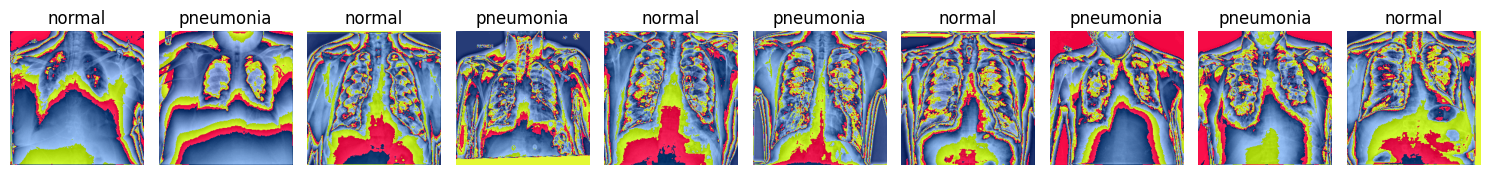

In [9]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1) 
        img = transforms.functional.to_pil_image(images[i])  
        plt.imshow(img)
        plt.title(f"{class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch in train_loader:
    X_batch, y_batch = batch
    class_names = train_dataset.classes
    display_images(X_batch[:10], y_batch[:10].tolist(), class_names)
    break

## Model Training And Evaluation

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"Device using for training: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch+1}/{num_epochs}]") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = sum(test_losses) / len(test_loader)
    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=1e-4)

num_epochs = 20
train_losses, train_accuracies, test_losses, test_accuracies = train_model(custom_model, train_loader, test_loader, criterion, optimizer, num_epochs)

Device using for training: cuda


Epoch [1/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22batch/s]


Epoch [1/20], Train Loss: 0.6975, Train Accuracy: 53.75%, Test Loss: 0.6741, Test Accuracy: 55.00%


Epoch [2/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89batch/s]


Epoch [2/20], Train Loss: 0.6662, Train Accuracy: 67.50%, Test Loss: 0.6084, Test Accuracy: 82.50%


Epoch [3/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15batch/s]


Epoch [3/20], Train Loss: 0.6344, Train Accuracy: 70.00%, Test Loss: 0.5176, Test Accuracy: 72.50%


Epoch [4/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03batch/s]


Epoch [4/20], Train Loss: 0.6113, Train Accuracy: 72.50%, Test Loss: 0.5167, Test Accuracy: 75.00%


Epoch [5/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13batch/s]


Epoch [5/20], Train Loss: 0.6350, Train Accuracy: 56.25%, Test Loss: 0.5622, Test Accuracy: 65.00%


Epoch [6/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01batch/s]


Epoch [6/20], Train Loss: 0.4829, Train Accuracy: 77.50%, Test Loss: 0.4649, Test Accuracy: 85.00%


Epoch [7/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13batch/s]


Epoch [7/20], Train Loss: 0.4775, Train Accuracy: 78.75%, Test Loss: 0.4718, Test Accuracy: 77.50%


Epoch [8/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15batch/s]


Epoch [8/20], Train Loss: 0.4146, Train Accuracy: 80.00%, Test Loss: 0.4333, Test Accuracy: 80.00%


Epoch [9/20]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15batch/s]


Epoch [9/20], Train Loss: 0.3764, Train Accuracy: 83.75%, Test Loss: 0.3986, Test Accuracy: 85.00%


Epoch [10/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05batch/s]


Epoch [10/20], Train Loss: 0.3261, Train Accuracy: 90.00%, Test Loss: 0.4082, Test Accuracy: 75.00%


Epoch [11/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12batch/s]


Epoch [11/20], Train Loss: 0.2842, Train Accuracy: 87.50%, Test Loss: 0.4108, Test Accuracy: 80.00%


Epoch [12/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10batch/s]


Epoch [12/20], Train Loss: 0.2585, Train Accuracy: 88.75%, Test Loss: 0.3585, Test Accuracy: 90.00%


Epoch [13/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05batch/s]


Epoch [13/20], Train Loss: 0.2153, Train Accuracy: 93.75%, Test Loss: 0.3448, Test Accuracy: 85.00%


Epoch [14/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02batch/s]


Epoch [14/20], Train Loss: 0.1653, Train Accuracy: 95.00%, Test Loss: 0.3136, Test Accuracy: 92.50%


Epoch [15/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01batch/s]


Epoch [15/20], Train Loss: 0.1376, Train Accuracy: 97.50%, Test Loss: 0.2516, Test Accuracy: 90.00%


Epoch [16/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch [16/20], Train Loss: 0.1187, Train Accuracy: 93.75%, Test Loss: 0.5061, Test Accuracy: 70.00%


Epoch [17/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97batch/s]


Epoch [17/20], Train Loss: 0.0858, Train Accuracy: 98.75%, Test Loss: 0.3116, Test Accuracy: 92.50%


Epoch [18/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01batch/s]


Epoch [18/20], Train Loss: 0.0678, Train Accuracy: 98.75%, Test Loss: 0.5238, Test Accuracy: 72.50%


Epoch [19/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07batch/s]


Epoch [19/20], Train Loss: 0.0543, Train Accuracy: 98.75%, Test Loss: 0.3222, Test Accuracy: 90.00%


Epoch [20/20]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97batch/s]


Epoch [20/20], Train Loss: 0.0321, Train Accuracy: 100.00%, Test Loss: 0.4092, Test Accuracy: 85.00%


## Model Evaluation

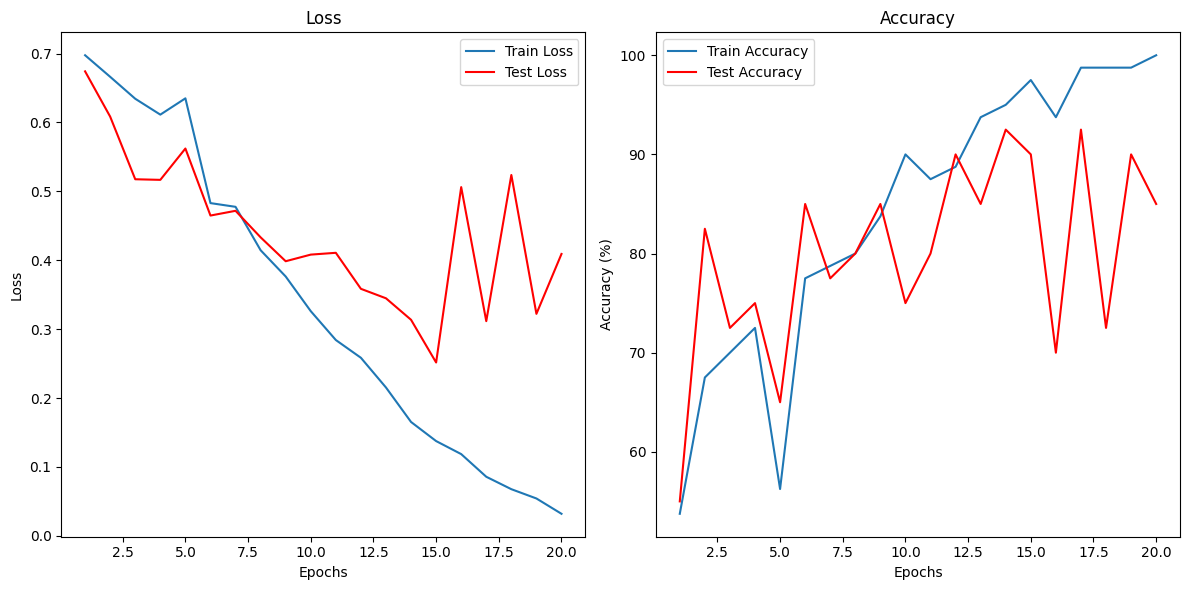

In [13]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss", color="r")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy", color="r")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

## Model Saving

In [14]:
# torch.save(custom_model.state_dict(), "../models/modelv1.2.pth")